# PRC 

> This module contains tools for simulating models against human phase response curve data. 

In [ ]:
#| default_exp prc

In [ ]:
#| hide 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.basics import *

In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt
from circadian.lights import LightSchedule
from circadian.models import CircadianModel, Hannay19

In [ ]:
#| export 
#| hide
# TODO: Finish implementing this 
class RimmerLightPulseLight:
    def __init__(self) -> None:
        pass 

    @staticmethod
    def make_pulse_rimmer(t: float, 
                          tstart: float, 
                          tend: float):
        val = 0.0
        steep = 100.0
        trans = 25.0/60.0

        val += 9500*(0.5*np.tanh(steep*(t-tstart))-0.5*np.tanh(steep*(t-t)))

        if ((t < tstart) and (t > tstart-trans)):
            val = 5000.0
            factor = np.floor((t-tstart+trans)*60.0/5.0)
            val += factor*1000.0

        if ((t > t) and (t < t+trans)):
            val = 9500.0
            factor = np.floor((t-t)*60.0/5.0)
            val -= factor*1000.0

        return(val)

    @staticmethod
    def pulse_rimmer_start(t: float, 
                             tstart: float, 
                             tend: float):

        val = 0.0
        steep = 100.0
        trans = 25.0/60.0

        val += 9500*(0.5*np.tanh(steep*(t-tstart))-0.5 *
                    np.tanh(steep*(t-t)))  # main pulse

        if ((t < tstart) and (t > tstart-trans)):
            val = 5000.0
            factor = np.floor((t-tstart+trans)*60.0/5.0)
            val += factor*1000.0

        return(val)

In [ ]:
#| export
#| hide
# TODO: Replace the use of these two functions with LightSchedules
def make_pulse(t, tstart, tend, steep: float=30.0):
    return 0.5*np.tanh(steep*(t-tstart))-0.5*np.tanh(steep*(t-tend))

def get_pulse(t: float,
              t1: float,
              t2: float,
              repeat=False,
              Intensity: float = 150.0):

    if repeat:
        t = np.fmod(t, 24.0)
    if t < 0.0:
        t += 24.0

    light_value = Intensity*make_pulse(t, t1, t2)
    return np.abs(light_value)

In [ ]:
#| export 
#| hide
class PhaseResponseCurveLight:
    def __init__(self) -> None:
         pass 
     
    def light_khalsa(t: float, 
                     CR: float):
        # Implement a Khalsa Light Schedule give a parameter for the initial CR length */

        low_light = 15.0  # from the paper
        val = low_light*make_pulse(t, 0.0, CR)+low_light*make_pulse(t,
                                                                    CR+8.0, CR+24.0)+low_light*make_pulse(t, CR+32.0, CR+1000.0)
        val += 9985.0*make_pulse(t, CR+8.0+4.65, CR+8.0+11.35)
        return(val)

    def light_hilaire(t: float,
                      CR: float):

        low_light = 3.0  # amount of light during CR (verified 1/16/17)
        val = low_light*make_pulse(t, 0, CR)+low_light*make_pulse(t,
                                                                CR+8, CR+24)+low_light*make_pulse(t, CR+32, CR+1000)
        val += 7997*make_pulse(t, CR+8+7.5, CR+8+8.5)
        return(val)

    def light_amplitude_resetting(t: float, 
                  CR: float):

        roomLight = 150.0
        afterLight = 150.0
        beforeLight = 150.0
        val = 0.0

        val += beforeLight*make_pulse(t, 0, CR)
        val += roomLight*make_pulse(t, CR+8, CR+24)
        val += 0.02*make_pulse(t, 0+24.0, CR+24.0)+roomLight * \
            make_pulse(t, CR+8+24.0, CR+48.0)
        val += afterLight*make_pulse(t, CR+48.0+8.0, CR+24+48.0+1000)
        val += 9850*make_pulse(t, CR+8+8-2.5, CR+8+8+2.5) + \
            9850*make_pulse(t, CR+8+8-2.5+24.0, CR+8+8+2.5+24.0)
        return(val)
    
    def light_czeiler_type0(t: float, CR: float):
        roomLight = 150.0
        afterLight = 150.0  # 150.0
        beforeLight = 150.0  # 150.0

        val = 0.0

        val += beforeLight*make_pulse(t, 0, CR)
        val += roomLight*make_pulse(t, CR+8, CR+24)
        val += 0.02*make_pulse(t, 0+24.0, CR+24.0)+roomLight * \
            make_pulse(t, CR+8+24.0, CR+24+24.0)
        val += 0.02*make_pulse(t, 0+48.0, CR+48.0)+roomLight * \
            make_pulse(t, CR+8+48.0, CR+24+48.0)
        val += afterLight*make_pulse(t, CR+24+48.0+8.0, CR+24+48.0+1000)
        val += 9850*make_pulse(t, CR+8+8-2.5, CR+8+8+2.5)+9850*make_pulse(t, CR+8+8 -
                                                                        2.5+24.0, CR+8+8+2.5+24.0)+9850*make_pulse(t, CR+8+8-2.5+48.0, CR+8+8+2.5+48.0)
        return(val)

In [ ]:
#| export 
#| hide
def heaviside(x: float) -> float:
    if x < 0:
        return 0
    else:
        return 1
    
class PRCFinder:
    
    @property
    def type0x(self) -> np.ndarray:
        return [16.2593, 16.304, 16.3018, 16.2738, 16.493, 16.7512, 17.9321, 19.1632,
                20.0534, 20.2959, 20.4188, 20.6394, 20.787, 21.1123, 21.1377,
                21.1579, 21.183, 21.2433, 21.2689, 22.2468, 25.2147, 27.1642,
                27.1974, 27.2108, 27.2363, 27.257, 27.5736, 27.8422, 28.0516,
                28.3226, 28.3779, 28.4506, 28.6003, 28.6608, 28.7964, 28.8359,
                28.8422, 29.0239, 29.0813, 29.1065, 29.1506, 29.2144, 29.2561,
                29.4005, 29.8354, 26.0773, 25.5784, 24.256, 20.0592, 15.2187,
                6.93359, 6.95777, 6.98051, 7.00128, 7.08384, 7.99415, 8.25918,
                8.7184, 8.91649, 8.97987, 9.2621, 9.30382, 9.47454, 10.3813, 10.8293,
                10.8903, 10.9258, 11.0337, 11.8089, 16.15, 16.3256, 16.363, 16.3653,
                16.6808, 16.7064]
    
    def exp_type0(x: float, b: float):
        val=(-1.57154+0.228932/(-1.0*b+x)-0.650632*x)*heaviside(b-x)+(9.66876+0.1321196/(-1.0*b+x)-0.463105*x)*heaviside(x-b)
        if (val < -12.0):
            return(-12.0)
        if (val > 12.0):
            return(12.0)

        return val
    
    @staticmethod
    def prc_type0_point(CRlength: float, initial_value: np.ndarray, model: CircadianModel) -> float:
        """
        Gives a single point from the Type 0 Human protocol. The initial cond
        passed in should already be entrained to a regular routine.
        CRlengths for the model fit were taken to vary in the range (6.0,30.0)
        every 0.05. However, this was just for convience.
        Every data point in this study is actually a diffirent person so the
        parameters should be allowed to vary for each computed point.....
        """
        CRFinal = 30.0
        tend = 72.0 + 8.0 + 30.0 + CRFinal
        time = np.arange(0, tend, 0.10)
        light_vals = np.array([PhaseResponseCurveLight.light_czeiler_type0(t, CRlength) for t in time])
        trajectory = model(time, initial_value, light_vals)
        CBT = model.cbt()
        shift = (CBT[0] - CBT[-1]) % 24.0 #finds a neg number between zero and -24.0

        #now shifts live in the range (-12,12) hours
        if (shift < -12.0):
            shift += 24.0

        #Now find the phase of the stimulus
        phase = (CRlength - CBT[0] + 12.0 + 16.0 - 2.5) % 24.0
        return phase,shift

C:\Users\tavel\AppData\Local\Temp\ipykernel_14516\3293739244.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  val=(-1.57154+0.228932/(-1.0*b+x)-0.650632*x)*heaviside(b-x)+(9.66876+0.1321196/(-1.0*b+x)-0.463105*x)*heaviside(x-b)


Text(0, 0.5, 'Phase Shift')

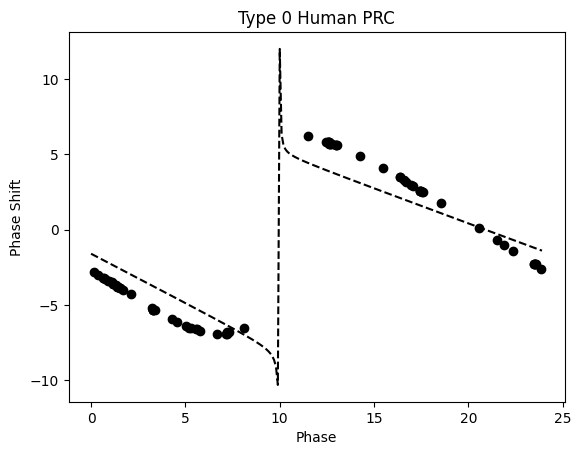

In [ ]:
model = Hannay19()

light_schedule = LightSchedule.Regular(lux=1000.0)
time = np.arange(0.0, 24.0, 0.10) 
light = light_schedule(time)
initial_conditions = model.equilibrate(time, input=light, num_loops=100)

phases = [] 
shifts = [] 
for cr in PRCFinder().type0x:
    phase,shift = PRCFinder.prc_type0_point(cr, initial_conditions, model)
    phases.append(phase)
    if shift > 12.0:
        shift -= 24.0
    shifts.append(shift)

xVals = np.arange(0,24,0.1)
yVals = np.array([PRCFinder.exp_type0(x, 10.0) for x in xVals])
plt.scatter(phases, shifts, color='black');
plt.plot(xVals, yVals, color='black', ls='--');

plt.title("Type 0 Human PRC");
plt.xlabel("Phase") 
plt.ylabel("Phase Shift")

In [ ]:
#| export 
#| hide
class IntensityResponseCurveLight:
    def __init__(self) -> None:
         pass
     
    @staticmethod
    def light_intensity(t, Intensity):
        """
        Define the light schedule for the dosage response curve experiments. All light exposures started at phi 6.75 hours
        before Tmin and lasted 6.5 hours of varying intensities
        """
        cr_light_level = 10.0  # verified, in the statistics section of the methods
        wake_light_level = 10.0  # verified
        wake_stimulus_light_level = 0.03
        sleep_light_level = 0.03
        stimulus_light_level = Intensity

        w = 50.0  # length of the constant routine, should be approx 50 hours, did have 50.0-9.50
        val = 0.0
        val += cr_light_level*make_pulse(t, 0, w)  # 50 hour constant routine
        val += sleep_light_level*make_pulse(t, w, w+8.0)  # eight hour sleep bout
        val += wake_stimulus_light_level * \
            make_pulse(t, w+8.0, w+24.0)  # wake/stimulus period
        val += (stimulus_light_level-wake_stimulus_light_level)*make_pulse(t, w+16.0 -
                                                                        3.25, w+16.0+3.25)  # the stimulus centered during the 16 hours of wakefulness
        # sleep period following stimulus
        val += sleep_light_level*make_pulse(t, w+24.0, w+32.0)
        # final cr to assess the phase shift induced
        val += cr_light_level*make_pulse(t, w+32.0, w+32.0+30.0)

        # Stimulus should start 5.25 hours after phase zero, so that it is centered 3.5 hours before Tmin
        return(val)

In [ ]:
#| export
#| hide
class DosageResponseCurve:
    
    def __init__(self) -> None:
         pass
     
    @staticmethod
    def light_dosage(t: float, length: float):
        # Implement the Light Schedule for Chang et al's Dosage Response Curve */
        CR1 = 48.0  # approx 50.0
        CR2 = 30.0
        CR_light_level = 1.0
        stimulus_light_level = 10000.0
        wake_light_level = 3.0

        val = 0.0
        val += CR_light_level*make_pulse(t, 0.0, CR1)
        val += wake_light_level*make_pulse(t, CR1+8.0, CR1+8.0+16.0)
        if (length == 0.2):
            val += stimulus_light_level * \
                make_pulse(t, CR1+8.0+8.5-length/2.0-12.0/60.0,
                            CR1+8.0+8.5+length/2.0-12.0/60.0)
        else:
            val += stimulus_light_level * \
                make_pulse(t, CR1+8.0+8.5-length/2.0, CR1+8.0+8.5+length/2.0)

        val += CR_light_level*make_pulse(t, CR1+32.0, CR1+32.0+30.0)

        return(val)

    @staticmethod
    def light_dosage_day1(t):
        # Implement the prep day just before the constant routine in the Chang et al Duration Response Curve protocol */
        s = t % 24.0
        val = 0.0
        if (s < 8.0):
            val = 90.0
        if ((s >= 8.0) and (s <= 16.0)):
            val = 3.0
        return(val)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()